# Display VAW
**Get visual intuitions from data**


First, I need the geography of the city. The smaller the geography, the better the spatial data analysis will be. For this task, I use the Basic Unit of the National Geostatistical Framework (AGEB) that provides an small enough  boundary layer. Additionally, working with AGEB will be useful for future analyses that include census data, since it represents the common framework for any data sets of the Mexican Institute of Statistics (INEGI). 


## Get Block Groups Data from Mexican National Geoinformation Portal

 The portal has several options for formats to export. In this case, I select Shapefile format.

The data set is licensed under the Mexican open data licence (CC BY-NC 2.5 MX).

* Date source:

    [Área geoestadística básica urbana, 2019 - Portal de Geoinformación 2022](http://geoportal.conabio.gob.mx/metadatos/doc/html/agbumge19gw.html)

* Data Structure:

  Structure of the data is described in a separate pdf file [link here](https://github.com/cecilia-sartori/gs-exam/blob/main/docs/pdf/contenido.pdf)



In [1]:
%%capture
!pip install rtree==0.9.7
!pip install pygeos==0.10.2
!pip install mapclassify==2.4.3
!pip install folium==0.12.1
!pip install contextily==1.2.0
!pip install geopandas==0.10.2

In [2]:
# Import required modules
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import plotly.express as px
import folium
from folium import plugins

/usr/local/lib/python3.7/dist-packages/geopandas/_compat.py:115: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [3]:
!wget -P data/ http://www.conabio.gob.mx/informacion/gis/maps/geo/agbumge19gw.zip
!unzip data/agbumge19gw.zip -d data/ageb

--2022-05-08 17:06:56--  http://www.conabio.gob.mx/informacion/gis/maps/geo/agbumge19gw.zip
Resolving www.conabio.gob.mx (www.conabio.gob.mx)... 200.12.166.9
Connecting to www.conabio.gob.mx (www.conabio.gob.mx)|200.12.166.9|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 43860165 (42M) [application/zip]
Saving to: ‘data/agbumge19gw.zip’

agbumge19gw.zip     100%[===================>]  41.83M  2.75MB/s    in 15s     

2022-05-08 17:07:11 (2.80 MB/s) - ‘data/agbumge19gw.zip’ saved [43860165/43860165]

Archive:  data/agbumge19gw.zip
  inflating: data/ageb/agbumge19gw.dbf  
  inflating: data/ageb/agbumge19gw.html  
  inflating: data/ageb/agbumge19gw.png  
  inflating: data/ageb/agbumge19gw.prj  
  inflating: data/ageb/agbumge19gw.shp  
  inflating: data/ageb/agbumge19gw.shx  
  inflating: data/ageb/agbumge19gw.xml  
 extracting: data/ageb/agbumge19gw_s.png  


In [4]:
# Read the data
gdf = gpd.read_file('data/ageb/agbumge19gw.shp')
gdf.sample(2)

,CVEGEO,CVE_ENT,CVE_MUN,CVE_LOC,CVE_AGEB,NOM_ENT,NOM_MUN,AREA,PERIMETER,COV_,COV_ID,geometry
54162,0803700014688,08,037,0001,4688,Chihuahua,JuÃ¡rez,0.440036,2.981689,54162,54163,"POLYGON ((-106.37832 31.65236, -106.37739 31.6..."
27601,2031800090418,20,318,0009,0418,Oaxaca,San Pedro Mixtepec,0.467035,3.862295,27601,27602,"POLYGON ((-97.07453 15.88343, -97.07406 15.883..."


CVEGEO is the concatenated geostatistical key that summarises all subsequent elements. This key will be crucial for merging AGEB data with other sources. 

Keep only Mexico City by using the corresponding federal entity key, equal to `09` ([source](/pdf/municipios.pdf)).

In [5]:
gdf = gdf[gdf['CVE_ENT'] == '09']

Proceed by filtering the data to only include the relevant columns, namely `CVEGEO` and `geometry`.

In [6]:
gdf = gdf[['CVEGEO', 'geometry']]

Inspect the geometries by plotting with matplotlib.  

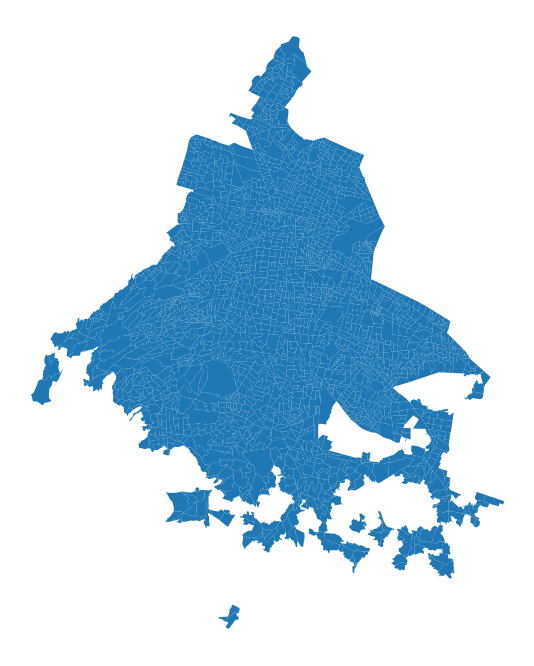

In [7]:
fig, ax = plt.subplots(figsize=(12,12))

gdf.plot(ax=ax)

plt.axis('off') 
plt.show()

Is this Mexico City? 
To check it, add a basemap. 
Running the code in the notebook, this can be done easily with the following line of code.

In [8]:
gdf.explore()

Output hidden; open in https://colab.research.google.com to view.

What if you run outside jupyter environment? You can use `contextily` to add a basemap to the static map of the geometries.

This package assumes that the Coordinate Reference Systems of the data is in Spherical Mercator (EPSG:3857), unless other crs is specified ([documentation](https://contextily.readthedocs.io/en/latest/reference.html)). 

So, first check CRS format of our data.

**Dealing With Coordinate Reference Systems (CRS)**

In [9]:
# check the CRS
gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

As can be seen above, the CRS is in EPSG:4326. So, to plot the basemap, I can either specify the parameter or reproject the data into EPSG 3857. 

Overall, EPSG 3857 is the preferred CRS for web maps, so I opt for reprojecting.


In [10]:
# reproject to web mercator
gdf = gdf.to_crs(epsg=3857)

And plot the city geometries with the basemap.

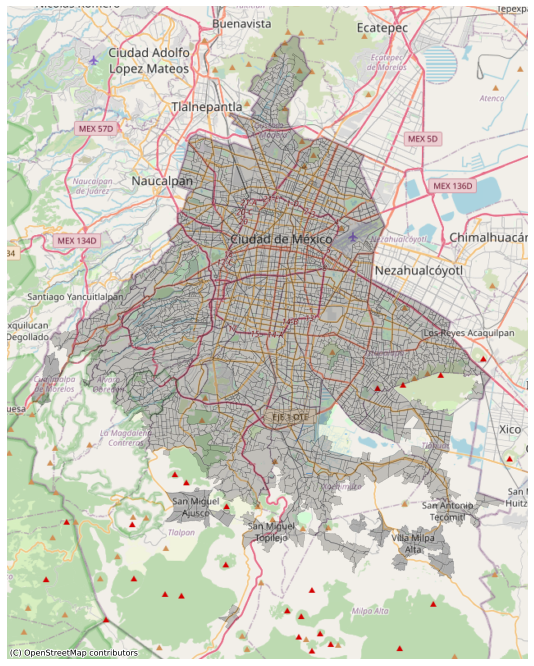

In [11]:
fig, ax = plt.subplots(figsize=(12,12))

gdf.plot(ax=ax,
         color='black', 
         edgecolor='black',
         lw=0.5,
         alpha=0.2,
         )

ax.axis('off')

# add basemap
ctx.add_basemap(ax,source=ctx.providers.OpenStreetMap.Mapnik)


Now that the spatial information is proven to be correct, let's enrich the geometries with the latest census of population and housing (2020). This makes the data much more informative about the socioeconomic status of the people living in each block and provides the explanatory variables for futere spatial regression analysis.

## Get data of 2020 Census of Population and Housing


The data set is licensed under the Mexican open data licence (CC BY-NC 2.5 MX).

* Date source:

    [Censo de Población y Vivienda 2020 - INEGI](https://www.gob.mx/inea/documentos/resultados-del-censo-de-poblacion-y-vivienda-2020-inegi)
    
    

* Data Structure:

    Structure of the data is described in a separate pdf file ([link here]())
    
    
    

The data below have been roughly cleaned before importing. See the step [here](). 

In [12]:
df = pd.read_csv('https://raw.githubusercontent.com/cecilia-sartori/gs-exam/main/notebooks/data/census_data2020.csv')
df.head()

,CVEGEO,ENTIDAD,NOM_ENT,MUN,NOM_MUN,LOC,NOM_LOC,AGEB,MZA,POBTOT,...,VPH_TELEF,VPH_CEL,VPH_INTER,VPH_STVP,VPH_SPMVPI,VPH_CVJ,VPH_SINRTV,VPH_SINLTC,VPH_SINCINT,VPH_SINTIC
0,0900200010010,9,Ciudad de México,2,Azcapotzalco,1,Total AGEB urbana,0010,0,3183.0,...,741.0,772.0,692.0,313.0,221.0,145.0,8.0,14.0,148.0,5.0
1,0900200010025,9,Ciudad de México,2,Azcapotzalco,1,Total AGEB urbana,0025,0,5593.0,...,1373.0,1510.0,1203.0,478.0,349.0,238.0,28.0,68.0,393.0,14.0
2,090020001003A,9,Ciudad de México,2,Azcapotzalco,1,Total AGEB urbana,003A,0,4235.0,...,965.0,1049.0,878.0,361.0,339.0,247.0,5.0,12.0,250.0,0.0
3,0900200010044,9,Ciudad de México,2,Azcapotzalco,1,Total AGEB urbana,0044,0,4768.0,...,1124.0,1237.0,1076.0,481.0,452.0,294.0,10.0,17.0,254.0,0.0
4,0900200010097,9,Ciudad de México,2,Azcapotzalco,1,Total AGEB urbana,0097,0,2176.0,...,517.0,562.0,507.0,276.0,260.0,153.0,4.0,3.0,70.0,0.0


As can be seen, census dataset comes with a lot of information. Column headers are defined in the data structure file mentioned above. Here below find the description of what I consider interesting to keep. Drop the rest.



| CODE         | CATEGORY   | DESCRIPTION  |
|--------------|-----------|:-----------|
| **CVEGEO** | GEO | Geostatistical key|
| **POBTOT**| POPULATION | Total number of people habitually living in the federal entity |
| **PRESOE15**  | MIGRATION | Population from 5 to 130 years of age who in 2015 resided in another federal entity |
| **P5_HLI** | ETNICITY | Population from 5 to 130 years of age who speak an indigenous language |
| **POB_AFRO** | ETNICITY | Population that considers itself Afro-Mexican or Afro-descendant |
| **GRAPROES** | EDUCATION | Average degree of education |
| **PDESOCUP** | OCCUPATION | Population of 12 years and more unemployed |
| **PSINDER** | HEALTH | Population with no access to health care |
| **VPH_SINLTC**| DIGITAL ACCESS | Homes with no landline or cell phone  |
| **VPH_SINCINT** | DIGITAL ACCESS | Homes with no computer or Internet |


Transfer census attributes to AGEB GeoDataFrame by merging on the geostatistical key. Put gdf on the left to keep spatial format in the resulting output.

In [13]:
gdf = pd.merge(gdf, df[['CVEGEO', 'POBTOT', 'PRESOE15',
                        'P5_HLI', 'POB_AFRO', 'GRAPROES',
                        'PDESOCUP', 'PSINDER', 'VPH_SINLTC' ,
                        'VPH_SINCINT']], on="CVEGEO")

Some AGEB unit are very small and might refer to few or no people. Get rid of blocks groups with less than 100 total population to further clean the data.

In [14]:
gdf = gdf[gdf['POBTOT']>100]

Finally, retrieve the data about violence against women from the Mexico City's Open Data Portal.

### Get VAW Data from CMDX Open Data Portal

VAW data of Mexico City is included in the crime victim dataset. This means that I have to identify which rows are significant to the project based on the description of the crime and the victim's gender.

The data set is licensed under the open data licence (CC BY 4.0).

* Date source:

    [Crime victims complaints - Mexico City Open Data Portal](https://datos.cdmx.gob.mx/dataset/victimas-en-carpetas-de-investigacion-fgj)



* Data Structure:

    Structure of the data is described in a separate excel file ([download here](https://datos.cdmx.gob.mx/dataset/victimas-en-carpetas-de-investigacion-fgj/resource/10235569-f4a9-4876-9465-9780887df8e2))
    
**This datasets have been extensively pre-processed [here]()**

In [15]:
# Read data
vaw = pd.read_csv('https://raw.githubusercontent.com/cecilia-sartori/gs-exam/main/notebooks/data/vaw_filtered.csv')
vaw.head()

,Time,Crime,latitude,longitude
0,01/01/2021,DOMESTIC VIOLENCE,19.198153,-99.026277
1,01/01/2021,DOMESTIC VIOLENCE,19.193027,-99.095006
2,01/01/2021,DOMESTIC VIOLENCE,19.336963,-99.152265
3,01/01/2021,DOMESTIC VIOLENCE,19.561525,-99.146590
4,01/01/2021,DOMESTIC VIOLENCE,19.395045,-99.061060


**Exploring data: Types of violence against women in Mexico City**

Most violence against women is perpetrated by current or former intimate partner and occurs in domestic settings, according to UN ([source](https://www.who.int/publications/i/item/9789240022256a)). Find out what type occurs most in CDMX using an interactive bar plot.

In [16]:
# create a copy to compute required values for the plot
data = vaw.copy() 

# convert time to a datetime64 type 
data['Time'] = pd.to_datetime(data['Time'])
data['Month'] = data['Time'].dt.month # extract the numeric value of months

# group crime by type and count occurrence
occur_type = pd.DataFrame(data.groupby(['Crime', 'Month']).size())
occur_type = occur_type.rename(columns = {0:'Reported'}) # rename the column

# order from Jan to Dec
occur_type.sort_values(["Month"],axis=0, ascending=True, inplace=True)
occur_type.reset_index(inplace = True) # reset index

occur_type.tail(5)

,Crime,Month,Reported
69,FEMICIDE,12,4
70,DOMESTIC VIOLENCE,12,661
71,AGAINST SEXUAL INTIMACY,12,26
72,SEXUAL ABUSE,12,76
73,SEXUAL HARASSMENT,12,26


In [17]:
# and plot it
fig = px.bar(occur_type, x="Month", y='Reported',
             color="Crime",
             hover_data={'Crime' : True ,
                         'Month' : False
                               },
             # costumize colours
             color_discrete_map={"DOMESTIC VIOLENCE": "darkblue",
                                 "FEMINICIDE": "royalblue",
                                 "SEXUAL HARASSMENT" : "cornflowerblue",
                                 "SEXUAL ABUSE": "deeppink",
                                },
             labels={"Crime" : "Type of violence",
                     "Reported": "Reported violence"},
             title='Reported Violence Against Women in CDMX by Type, 2021')


fig.update_layout(
        legend=dict(
        orientation="h",
        y = - 0.2
        ),
    legend_title_text=''

)


config = dict({'displayModeBar': False})

#fig.write_html("output/VAW_in_CDMX_byType.html",config=config)
fig.show(config=config)

Click on the legend entries to hide and show traces. 

The trend stated by UN have proven to be true for Mexico City. It is worth noting that the number of reported violence is stable throughout the year, but decreases significantly in the months of November and December, revealing that perhaps during the holidays it is more difficult for women to report.

**End of Digression**

Back to VAW dataframe. Print a summary of the data types:

In [18]:
# get the data types
vaw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25419 entries, 0 to 25418
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Time       25419 non-null  object 
 1   Crime      25419 non-null  object 
 2   latitude   25419 non-null  float64
 3   longitude  25419 non-null  float64
dtypes: float64(2), object(2)
memory usage: 794.5+ KB


I can't plot this data on a map because no geometry is listed in the data type column. I need to convert the latitude and longitude into appropriate spatial information. 

In [19]:
# convert df to geodataframe
vaw_gdf = gpd.GeoDataFrame(vaw,
                         crs='EPSG:4326', # lat and long are in degree
                         geometry= gpd.points_from_xy(vaw.longitude, vaw.latitude))
vaw_gdf.head(3)

,Time,Crime,latitude,longitude,geometry
0,01/01/2021,DOMESTIC VIOLENCE,19.198153,-99.026277,POINT (-99.02628 19.19815)
1,01/01/2021,DOMESTIC VIOLENCE,19.193027,-99.095006,POINT (-99.09501 19.19303)
2,01/01/2021,DOMESTIC VIOLENCE,19.336963,-99.152265,POINT (-99.15227 19.33696)


Finally, I can plot the VAW locations. However, if many points are concentrated in some areas, then the dots overlap and this makes it hard to understand any pattern.

To represents the locations in a more informative way, use hexagonal cells.


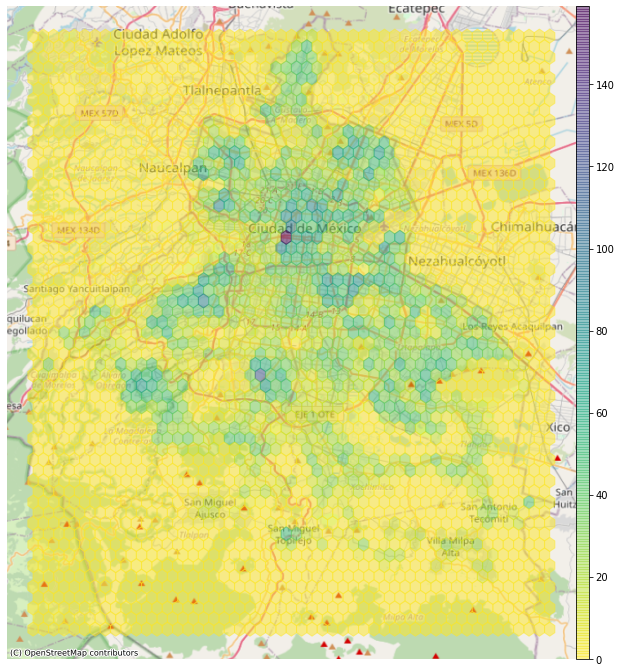

In [20]:
# plot hexbins with Matplotlib
fig, ax = plt.subplots(figsize=(12, 12))

hb= ax.hexbin(data=vaw_gdf,
    x = 'longitude',
    y= 'latitude',
    gridsize=50, # size of hexagonal cells
    alpha=0.5, 
    cmap='viridis_r'
)

# no axis
ax.axis('off')
# add bar side
fig.colorbar(hb, aspect=50, pad=0 );

# hexbin takes lat and lon as arguments --> specify crs
ctx.add_basemap(ax,
                source=ctx.providers.OpenStreetMap.Mapnik,
                crs=4326)

The color of each hexbin denotes the number of points in it. 

With this map, I can instantly draw conclusions. For instance, I see that most cases occurs near the city center.

## Combine Data

At this point, I have two GeoDataFrames: one with the AGEB polygons and the other with the points where the violence took place. I just have to join the two pieces of information with a spatial join.

To do that, I need both data sets with the same map projection.

In [21]:
# reproject vaw_gdf to web mercator
vaw_gdf = vaw_gdf.to_crs(epsg=3857)

The following code creates a GeoDataFrame that has every vaw record with the corresponding CVEGEO code.

In [22]:
join = gpd.sjoin(vaw_gdf, gdf, how='left')
join.head(3)

,Time,Crime,latitude,longitude,geometry,index_right,CVEGEO,POBTOT,PRESOE15,P5_HLI,POB_AFRO,GRAPROES,PDESOCUP,PSINDER,VPH_SINLTC,VPH_SINCINT
0,01/01/2021,DOMESTIC VIOLENCE,19.198153,-99.026277,POINT (-11023554.739 2178279.222),1089.0,0900900010308,3177.0,43.0,101.0,15.0,10.38,22.0,1568.0,61.0,290.0
1,01/01/2021,DOMESTIC VIOLENCE,19.193027,-99.095006,POINT (-11031205.607 2177674.892),1080.0,0900900330350,9142.0,149.0,210.0,27.0,10.11,64.0,2267.0,115.0,806.0
2,01/01/2021,DOMESTIC VIOLENCE,19.336963,-99.152265,POINT (-11037579.654 2194648.346),199.0,0900300010450,6576.0,155.0,58.0,48.0,13.21,101.0,1764.0,30.0,201.0


**What are the blocks with the highest rate of vaw?**

With the hexagonal cells map, I can understand the data distribution at a glance, but nothing about the block groups.

Therefore, create another dataframe that counts violence by their corresponding AGEB.

In [23]:
reported_by_gdf = join.CVEGEO.value_counts().rename_axis('CVEGEO').reset_index(name='VAW_COUNT')
reported_by_gdf.head()

,CVEGEO,VAW_COUNT
0,090150001113A,66
1,0901500010875,60
2,0901500011036,58
3,0900300010785,57
4,0900300010963,53


And now join it back to the AGEB gdf

In [24]:
gdf= gdf.merge(reported_by_gdf,on='CVEGEO')
gdf.head()

,CVEGEO,geometry,POBTOT,PRESOE15,P5_HLI,POB_AFRO,GRAPROES,PDESOCUP,PSINDER,VPH_SINLTC,VPH_SINCINT,VAW_COUNT
0,0900200010148,"POLYGON ((-11043669.988 2213993.494, -11043643...",2513.0,85.0,16.0,70.0,13.26,39.0,498.0,4.0,90.0,7
1,0900200010190,"POLYGON ((-11041773.412 2213843.334, -11041760...",8920.0,602.0,113.0,218.0,11.55,134.0,2011.0,76.0,600.0,34
2,0900200010932,"POLYGON ((-11041855.381 2215121.578, -11041824...",408.0,28.0,10.0,0.0,11.74,0.0,58.0,0.0,14.0,7
3,0900200010237,"POLYGON ((-11043811.972 2213166.667, -11043827...",7093.0,300.0,61.0,119.0,11.13,115.0,1881.0,63.0,434.0,24
4,0900200010595,"POLYGON ((-11044374.238 2211932.937, -11044339...",5116.0,251.0,65.0,42.0,10.59,70.0,1324.0,54.0,426.0,13


The GeoDataFrame now has the vaw count column. So I can easily query the data for finding maximum values. 
However, using the absolute count of violence would be misleading because it doesn't take into account the number of people living in the block. To solve this issue, let's compute the vaw rates per 1000 people by AGEB. 

In [25]:
gdf['VAW_per_1000'] = gdf['VAW_COUNT']/gdf['POBTOT']*1000

In [26]:
# Write to GeoJSON to avoid recalculation 

gdf.to_file("data/VAW_AGEB_clean.gjson", driver="GeoJSON")

And plot the Top 10 Most Dangerous Blocks:

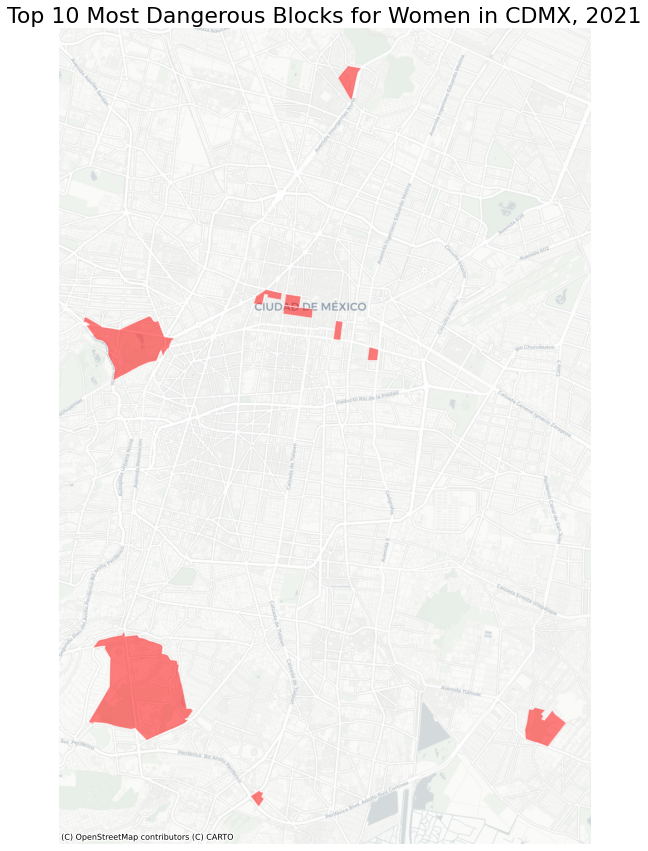

In [27]:
# plot the top 10 geographies
fig,ax = plt.subplots(figsize=(15,15))

gdf.sort_values(by='VAW_per_1000',ascending=False)[:10].plot(ax=ax,
                                                                 color='red',
                                                                 edgecolor='white',
                                                                 alpha=0.5,legend=True)


# title
ax.set_title('Top 10 Most Dangerous Blocks for Women in CDMX, 2021', fontsize=22)

# no axis
ax.axis('off')

# add a basemap
ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

Now visualise the total distribution with a choropleth map:

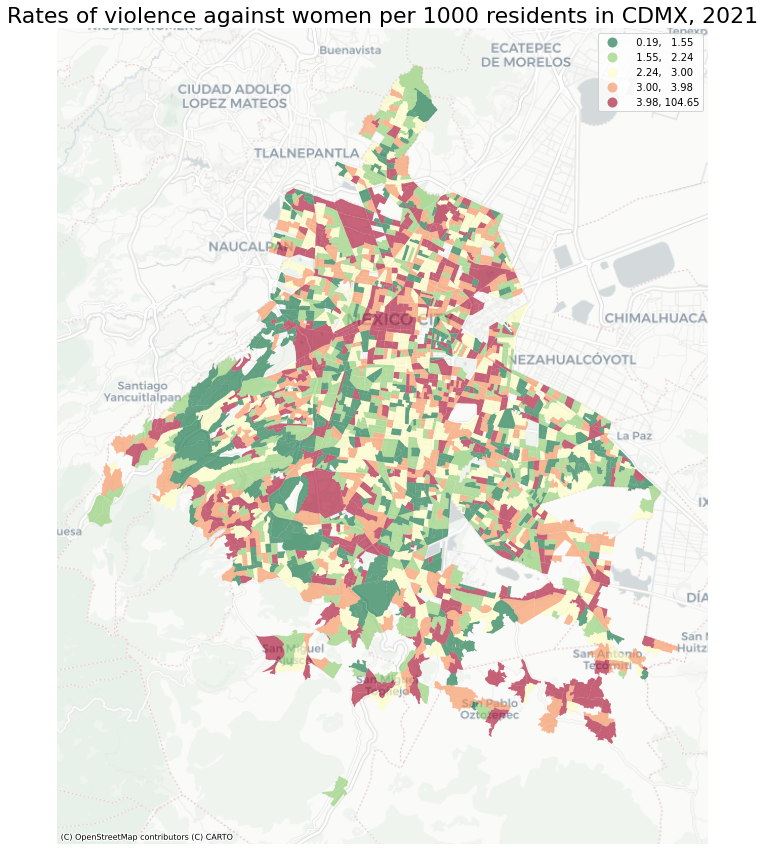

In [28]:
fig,ax = plt.subplots(figsize=(15,15))

gdf.plot(ax=ax,
        column='VAW_per_1000',
        legend=True,
        alpha=0.6,
        cmap='RdYlGn_r',
        scheme='quantiles')

ax.axis('off')
ax.set_title('Rates of violence against women per 1000 residents in CDMX, 2021',fontsize=22)

ctx.add_basemap(ax,source=ctx.providers.CartoDB.Positron)

The fugure above presents information in a simple, visual way. However, it would be much better for users to be free to zoom in some areas and play around, namely if the figure were interactive! I can use `folium` to accomplish the task.

Moreover, AGEB are really useful to understand whether similar geographies tend to cluster (and apparently they do in this case). But what about the district they belong to?
Let's find out the worst neighborhood to be a woman in Mexico City - as claimed by the title of the project - by fisrt importing the Neighborhood Data.


## Get Neighborhood Data

Data comes from Mexico City Open Data Portal and have been cleaned before importig. Find the pre-processign phase [here]().

In [29]:
# Read the data
gdf_mun = gpd.read_file('https://raw.githubusercontent.com/cecilia-sartori/gs-exam/main/notebooks/data/CDMX_municipalities.gjson')
# reproject to web mercator
gdf_mun = gdf_mun.to_crs(epsg=3857)

gdf_mun.head(3)

,CVEGEO,NOMGEO,POBTOT,geometry
0,9009,MILPA ALTA,152685,"POLYGON ((-11020321.650 2181716.432, -11020345..."
1,9014,BENITO JUÁREZ,434153,"POLYGON ((-11035857.497 2202270.237, -11035860..."
2,9005,GUSTAVO A. MADERO,1173351,"POLYGON ((-11033831.810 2223869.140, -11033643..."


Run the same operations performed before for AGEB.


In [30]:
# Make a spatial join
join = gpd.sjoin(vaw_gdf, gdf_mun, how="left")
# count vaw per neighbourhood
reported_by_gdf = join.CVEGEO.value_counts().rename_axis('CVEGEO').reset_index(name='VAW_COUNT')

In [31]:
gdf_mun= gdf_mun.merge(reported_by_gdf,on='CVEGEO')

In [32]:
#Compute rate per 1000
gdf_mun['VAW_per_1000'] = gdf_mun['VAW_COUNT']/gdf['POBTOT']*1000
gdf_mun.head()

,CVEGEO,NOMGEO,POBTOT,geometry,VAW_COUNT,VAW_per_1000
0,9009,MILPA ALTA,152685,"POLYGON ((-11020321.650 2181716.432, -11020345...",508,202.148826
1,9014,BENITO JUÁREZ,434153,"POLYGON ((-11035857.497 2202270.237, -11035860...",904,101.345291
2,9005,GUSTAVO A. MADERO,1173351,"POLYGON ((-11033831.810 2223869.140, -11033643...",3284,8049.019608
3,9003,COYOACÁN,614447,"POLYGON ((-11036128.811 2196996.411, -11035960...",1625,229.099112
4,9016,MIGUEL HIDALGO,414470,"POLYGON ((-11041844.793 2210106.057, -11041853...",1027,200.742768


We are now ready to combine the data into a single interactive map.

## Build an Interactive Choropleth Map

Display AGEB and neighbourhood in two FeatureGroup layers map:

In [33]:
#Create map instance, set location
vaw_map =folium.Map(location=[19.32096,-99.15261], 
                   tiles = 'cartodbpositron', 
                   zoom_start=10, control_scale=True, overlay=False)
#set two layer
fg1 = folium.FeatureGroup(name='VAW rate per AGEB',overlay=False).add_to(vaw_map)
fg2 = folium.FeatureGroup(name='VAW rate per Neighbourhood',overlay=False).add_to(vaw_map)


In [34]:
#Add the first choropleth map layer to fg1
custom_scale1 = (gdf['VAW_per_1000'].quantile((0,0.2,0.4,0.6,0.8,1))).tolist()

ageb = folium.Choropleth(
        geo_data=gdf,
        name='vaw in 2021',
        data=gdf,
        columns=['CVEGEO', 'VAW_per_1000'],
        key_on='feature.properties.CVEGEO',
        fill_color='YlOrRd',
        fill_opacity=0.7,
        line_opacity=0.2,
        line_color='white', 
        line_weight=0, 
        smooth_factor=1,
        threshold_scale=custom_scale1,
        legend_name= 'Rates of violence against women per 1000 in CDMX, 2021',
    overlay=False).geojson.add_to(fg1)


folium.features.GeoJson(
                    data=gdf,
                    smooth_factor=2,
                    style_function=lambda x: {'color':'white','fillColor':'transparent','weight':0.5},
                    tooltip=folium.features.GeoJsonTooltip(
                        fields=['POBTOT',
                                'VAW_COUNT',
                                'VAW_per_1000',
                                'PDESOCUP',
                                'GRAPROES'
                               ],
                        aliases=["Total Population, <br>(Per AGEB):",
                                 "Reported cases:",
                                 "VAW rate per 1000:",
                                 "Pop Unemployed:",
                                 "Degree of Education:"
                                ], 
                        localize=True,
                        sticky=False,
                        labels=True,
                        style="""
                            background-color: #F0EFEF;
                            border: 2px solid black;
                            border-radius: 3px;
                            box-shadow: 3px;
                        """,
                        max_width=800,),
                            highlight_function=lambda x: {'weight':3,'fillColor':'grey'},
                        ).add_to(ageb)

#Add the 2nd choropleth map layer to fg2
custom_scale2 = (gdf_mun['VAW_per_1000'].quantile((0,0.2,0.4,0.6,0.8,1))).tolist()

neighb = folium.Choropleth(
    geo_data=gdf_mun,
    name='vaw per Neighbourhood',
    data=gdf_mun,
    columns=['CVEGEO', 'VAW_per_1000'],
    key_on='feature.properties.CVEGEO',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.2,
    line_color='white', 
    line_weight=0, 
    smooth_factor=1,
    threshold_scale=custom_scale2,
    legend_name= 'Incidents of violence against women in CDMX, 2021',
    overlay=False).geojson.add_to(fg2)

folium.features.GeoJson(
                    data=gdf_mun,
                    smooth_factor=2,
                    style_function=lambda x: {'color':'white','fillColor':'transparent','weight':0.5},
                    tooltip=folium.features.GeoJsonTooltip(
                        fields=['NOMGEO',
                                'POBTOT',
                                'VAW_COUNT',
                                'VAW_per_1000',
                               ],
                        aliases=["Neighbourhood:",
                                 "Population:",
                                 "Reported Cases:",
                                 "VAW rate per 1000:"
                                 
                                ], 
                        localize=True,
                        sticky=False,
                        labels=True,
                        style="""
                            background-color: #F0EFEF;
                            border: 2px solid black;
                            border-radius: 3px;
                            box-shadow: 3px;
                        """,
                        max_width=800,),
                            highlight_function=lambda x: {'weight':3,'fillColor':'grey'},
                        ).add_to(neighb)   


#Add layer control to the map
folium.TileLayer('cartodbdark_matter',overlay=True,name="View in Dark Mode").add_to(vaw_map)
folium.TileLayer('cartodbpositron',overlay=True,name="Viw in Light Mode").add_to(vaw_map)
folium.LayerControl(collapsed=False).add_to(vaw_map)
#Add mini map
folium.plugins.MiniMap().add_to(vaw_map)

#vaw_map.save("output/CDMX_VAW_Folium.html") #save to a file
vaw_map

Output hidden; open in https://colab.research.google.com to view.

Et Voilà! Click on legend entries to hide and show the layer. 

The AGEB layer visually suggests that there are spatial clusters of where VAW is more prevalent, but can this pattern be a matter of chance?

To answer this question, I need to conduct the spatial correlation analysis.
Go to the next page.